In [11]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# === Config ===
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
FINE_TUNE_AT = 200
MODEL_PATH = r'C:\Aakash PDFs\Cyber S4\ML\Project\EffNet.keras'
TRAIN_SPLIT_FILE = r'C:\Aakash PDFs\Cyber S4\ML\Project\train_split.txt'
VAL_SPLIT_FILE = r'C:\Aakash PDFs\Cyber S4\ML\Project\val_split.txt'


In [3]:
# === Load split file paths ===
def read_split_file(split_file):
    image_paths, labels = [], []
    with open(split_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                path, label = parts
                image_paths.append(path)
                labels.append(int(label))
    return image_paths, labels

train_image_paths, train_labels = read_split_file(TRAIN_SPLIT_FILE)
val_image_paths, val_labels = read_split_file(VAL_SPLIT_FILE)



In [4]:
# === Preprocessing ===
def load_and_preprocess_image(path, label, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label


In [5]:
# === Dataset ===
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment=True),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
val_dataset = val_dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment=False),
                              num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



In [6]:
# === Model ===
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
# === Callbacks ===
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss')
]


In [8]:
# === Training ===
print("Initial training...")
model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks)


Initial training...
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 937ms/step - accuracy: 0.7083 - loss: 0.5441 - val_accuracy: 0.9763 - val_loss: 0.1346 - learning_rate: 1.0000e-04
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 887ms/step - accuracy: 0.9621 - loss: 0.1490 - val_accuracy: 0.9980 - val_loss: 0.0282 - learning_rate: 1.0000e-04
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 898ms/step - accuracy: 0.9916 - loss: 0.0548 - val_accuracy: 0.9980 - val_loss: 0.0141 - learning_rate: 1.0000e-04
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 57s 886ms/step - accuracy: 0.9951 - loss: 0.0332 - val_accuracy: 0.9980 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 56s 876ms/step - accuracy: 0.9972 - loss: 0.0215 - val_accuracy: 0.9980 - val_loss: 0.0054 - learning_rate: 1.0000e-04
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 899ms/step - accuracy: 0.9948 - loss: 0.0255 - val_accuracy: 1.0000 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 

In [9]:
# === Fine-tuning ===
print("Fine-tuning...")
base_model.trainable = True
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=7, callbacks=callbacks)


Fine-tuning...
Epoch 1/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9056 - loss: 0.2534 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 1.0000e-05
Epoch 2/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9733 - loss: 0.1337 - val_accuracy: 1.0000 - val_loss: 0.0034 - learning_rate: 1.0000e-05
Epoch 3/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9715 - loss: 0.1222 - val_accuracy: 1.0000 - val_loss: 0.0054 - learning_rate: 1.0000e-05
Epoch 4/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 971ms/step - accuracy: 0.9924 - loss: 0.0638 - val_accuracy: 1.0000 - val_loss: 0.0080 - learning_rate: 2.0000e-06
Epoch 5/7
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9843 - loss: 0.0783 - val_accuracy: 1.0000 - val_loss: 0.0096 - learning_rate: 2.0000e-06


In [12]:
# === Evaluation ===
val_preds = model.predict(val_dataset)
val_preds_labels = (val_preds > 0.5).astype(int).flatten()

true_labels = []
for _, lbls in val_dataset.unbatch():
    true_labels.append(int(lbls.numpy()))

print(confusion_matrix(true_labels, val_preds_labels))
print(classification_report(true_labels, val_preds_labels))

print("EffNet predictions shape:", val_preds.shape)
np.save('effnet_preds.npy', val_preds)


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 624ms/step
[[211   0]
 [  0 296]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       211
           1       1.00      1.00      1.00       296

    accuracy                           1.00       507
   macro avg       1.00      1.00      1.00       507
weighted avg       1.00      1.00      1.00       507

EffNet predictions shape: (507, 1)


In [ ]:
loss, acc = model.evaluate(val_dataset)
print(f"✅ Final Validation Accuracy: {acc:.4f}")



16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 738ms/step - accuracy: 1.0000 - loss: 2.2268e-05
Validation Accuracy: 1.00


In [ ]:
# === Save Model ===
model.save(MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 801ms/step


C:\Users\hunny\AppData\Local\Temp\ipykernel_11364\2829037399.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\hunny\AppData\Local\Temp\ipykernel_11364\2829037399.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


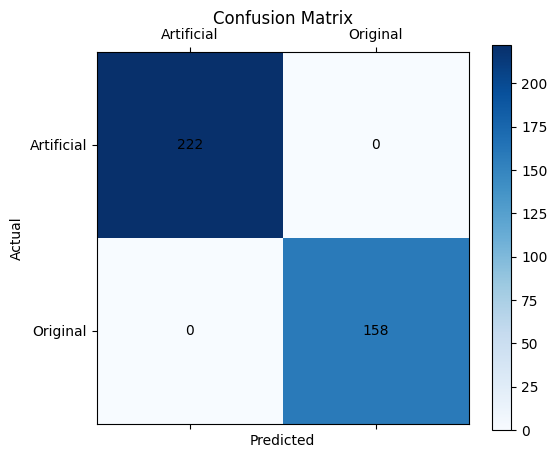

              precision    recall  f1-score   support

  Artificial       1.00      1.00      1.00       222
    Original       1.00      1.00      1.00       158

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380



In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predictions
val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = (pred_probs > 0.5).astype(int).flatten()
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

# Plot with matplotlib
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm, cmap='Blues')
plt.title('Confusion Matrix', pad=20)
fig.colorbar(cax)

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Annotate each cell
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center')

plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))


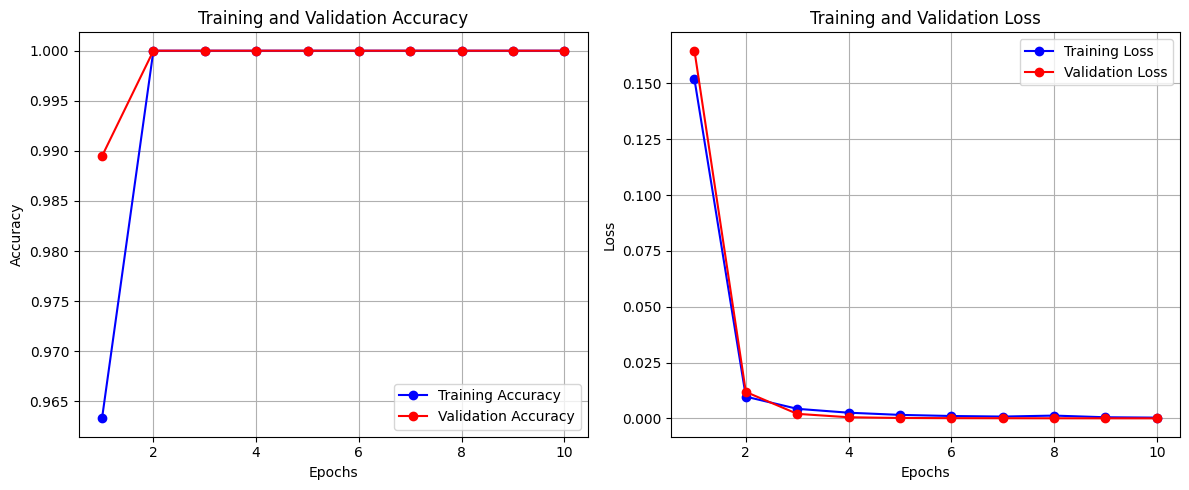

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
